In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import tensorflow as tf

np.random.seed(42)

df = pd.read_excel('../data/state_month_overdose.xlsx')

df['Deaths'] = df['Deaths'].apply(lambda x: 0 if x == 'Suppressed' else int(x))

df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

df = df.reset_index() #2015/01
df['Month Code'] = pd.to_datetime(df['Month Code'])#.reset_index() #2015-01-01
# df.set_index('Month', inplace=True)
df = df.groupby(['Month']).agg({'Deaths': 'sum'}).reset_index()



train = df[df['Month'] <= '2019-01-01']
test = df[(df['Month'] >= '2019-01-01') & (df['Month'] <= '2019-12-01')]
testog = test
test = test.reset_index().drop(columns = ['index'])



# Modify the create_dataset function to use a lookback of 3 months
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset.iloc[i:(i + look_back)]  # Collect the previous 'look_back' months
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back])  # The target is the subsequent month
    return np.array(dataX), np.array(dataY)

look_back = 3

extended_test = pd.concat([train.iloc[-look_back:], test])

# Prepare LSTM datasets
trainX, trainY = create_dataset(train['Deaths'], look_back)
testX, testY = create_dataset(extended_test['Deaths'], look_back)


# Reshape inputs to match LSTM input requirements (samples, time_steps, features)
trainX = trainX.reshape((trainX.shape[0], look_back, 1))
testX = testX.reshape((testX.shape[0], look_back, 1))

# Rebuild the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

# Updated generate_forecast function to handle 3-month lookback
def generate_forecast(model, initial_sequence, num_predictions=12, look_back=3):
    predictions = []
    for _ in range(num_predictions):
        # Generate the next prediction
        next_prediction = model.predict(initial_sequence)
        predictions.append(next_prediction[0][0])
        
        # Update the sequence with the new prediction
        new_sequence = np.append(initial_sequence[0, 1:], [[next_prediction[0][0]]], axis=0)
        initial_sequence = new_sequence.reshape((1, look_back, 1))

    return np.array(predictions)

# Prepare the initial sequence for forecasting using the last `look_back` months from training
initial_sequence = trainX[-1].reshape((1, look_back, 1))

# Generate test predictions with the updated lookback logic
testPredict = generate_forecast(model, initial_sequence, num_predictions=testY.shape[0], look_back=look_back)
trainPredict = model.predict(trainX)

# Flatten predictions for visualization and evaluation
testPredictlst = testPredict.flatten().tolist()
trainPredictlst = trainPredict.flatten().tolist()

# Combine actual data and predictions
combined_array = [0] * look_back + trainPredictlst + testPredictlst
df['LSTM Predictions'] = combined_array




sarima_model = SARIMAX(train['Deaths'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)
sarima_predictions = sarima_result.predict(start=0, end=len(train) + len(test) - 1, dynamic=False)

df['SARIMA Predictions'] = sarima_predictions

df.to_csv(f'/tables/{look_back}month_predictionresults_batch_1_loss_mse.csv')

plottable = df.iloc[1:] #only taking rows with predictions so excluding part included in first lookback
plottable.set_index('Month', inplace=True)

Epoch 1/100


/tmp/ipykernel_1381/4224147136.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Month'] = pd.to_datetime(df['Month'])
/tmp/ipykernel_1381/4224147136.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Month Code'] = pd.to_datetime(df['Month Code'])#.reset_index() #2015-01-01
/home/sukikrishna/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11310141.0000
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4171260.7500
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 177871.8125 
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 47731.0625
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 48632.6250
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 54592.0391
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34411.9766
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 45766.9297
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 67926.0469
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39241.6992
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38918.1367
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 43545.8828
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54587.6250 
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43153.7266
Epoch 1

ValueError: Length of values (61) does not match length of index (72)

In [4]:
# df[(df['Month'] >= '2019-01-01') & (df['Month'] <= '2019-12-01')]

,Month,Deaths
48,2019-01-01,3931
49,2019-02-01,3727
50,2019-03-01,4285
51,2019-04-01,3934
52,2019-05-01,4100
53,2019-06-01,4112
54,2019-07-01,4296
55,2019-08-01,4371
56,2019-09-01,4252
57,2019-10-01,4529


In [13]:
df

,Month,Deaths
0,2015-01-01,2771
1,2015-02-01,2627
2,2015-03-01,2907
3,2015-04-01,2822
4,2015-05-01,2850
...,...,...
67,2020-08-01,6165
68,2020-09-01,5683
69,2020-10-01,5613
70,2020-11-01,5613


In [6]:
trainX

array([[[2771],
        [2627],
        [2907]],

       [[2627],
        [2907],
        [2822]],

       [[2907],
        [2822],
        [2850]],

       [[2822],
        [2850],
        [2634]],

       [[2850],
        [2634],
        [2734]],

       [[2634],
        [2734],
        [2810]],

       [[2734],
        [2810],
        [2925]],

       [[2810],
        [2925],
        [2970]],

       [[2925],
        [2970],
        [2739]],

       [[2970],
        [2739],
        [2718]],

       [[2739],
        [2718],
        [3098]],

       [[2718],
        [3098],
        [3416]],

       [[3098],
        [3416],
        [3721]],

       [[3416],
        [3721],
        [3608]],

       [[3721],
        [3608],
        [3475]],

       [[3608],
        [3475],
        [3384]],

       [[3475],
        [3384],
        [3668]],

       [[3384],
        [3668],
        [3624]],

       [[3668],
        [3624],
        [3518]],

       [[3624],
        [3518],
        [3695]],



In [2]:
print(len(testY))
testY

11


array([4696, 5365, 6027, 7419, 6307, 6343, 6165, 5683, 5613, 5613, 5792])

In [3]:
trainY

array([3098, 3416, 3721, 3608, 3475, 3384, 3668, 3624, 3518, 3695, 3745,
       4044, 4332, 4006, 4252, 4056, 4129, 3950, 3980, 4000, 4022, 3832,
       3820, 4017, 4008, 3671, 4155, 3922, 4079, 4063, 4085, 4061, 3882,
       3999, 3692, 3976, 3931, 3727, 4285, 3934, 4100, 4112, 4296, 4371,
       4252, 4529, 4560, 4645, 4727, 4696])

In [4]:
print(len(testPredict))
testPredict

10


array([4442.727 , 4453.5566, 4464.598 , 4508.681 , 4539.0044, 4583.1094,
       4614.778 , 4644.7544, 4685.3276, 4693.248 ], dtype=float32)

In [5]:
testPredict[:len(testY)]

array([4442.727 , 4453.5566, 4464.598 , 4508.681 , 4539.0044, 4583.1094,
       4614.778 , 4644.7544, 4685.3276, 4693.248 ], dtype=float32)

In [6]:
len(sarima_predictions[1:len(trainPredict)+1])

50

In [7]:
sarima_predictions[len(trainPredict):len(trainPredict)+len(testY)]

50    4104.815995
51    4060.751985
52    4030.262811
53    3981.997153
54    4184.037754
55    4268.184320
56    4267.545126
57    4312.770399
58    4329.686557
59    4763.885546
60    4735.560962
Name: predicted_mean, dtype: float64

In [8]:
trainPredict

array([[2848.2148],
       [2921.9746],
       [3020.5   ],
       [3124.4404],
       [3170.591 ],
       [3196.559 ],
       [3235.4346],
       [3322.7317],
       [3367.0244],
       [3399.1538],
       [3487.1428],
       [3593.0513],
       [3733.9917],
       [3860.5605],
       [3854.0112],
       [3921.309 ],
       [3931.4895],
       [3973.8923],
       [3990.501 ],
       [4011.8525],
       [4054.024 ],
       [4114.556 ],
       [4100.893 ],
       [4108.912 ],
       [4123.245 ],
       [4107.5684],
       [4043.6895],
       [4078.2385],
       [4053.1895],
       [4066.4058],
       [4067.2588],
       [4071.1294],
       [4079.7637],
       [4050.3887],
       [4054.9365],
       [4030.7751],
       [4045.7876],
       [4049.3545],
       [4033.9985],
       [4107.8794],
       [4079.3225],
       [4085.368 ],
       [4095.1992],
       [4120.5693],
       [4163.0254],
       [4173.0776],
       [4232.3975],
       [4322.8438],
       [4373.367 ],
       [4442.727 ]],

LSTM
Train Score: 277.41 RMSE
Test Score: 1523.70 RMSE
SARIMA
Train Score: 543.60 RMSE
Test Score: 1799.60 RMSE


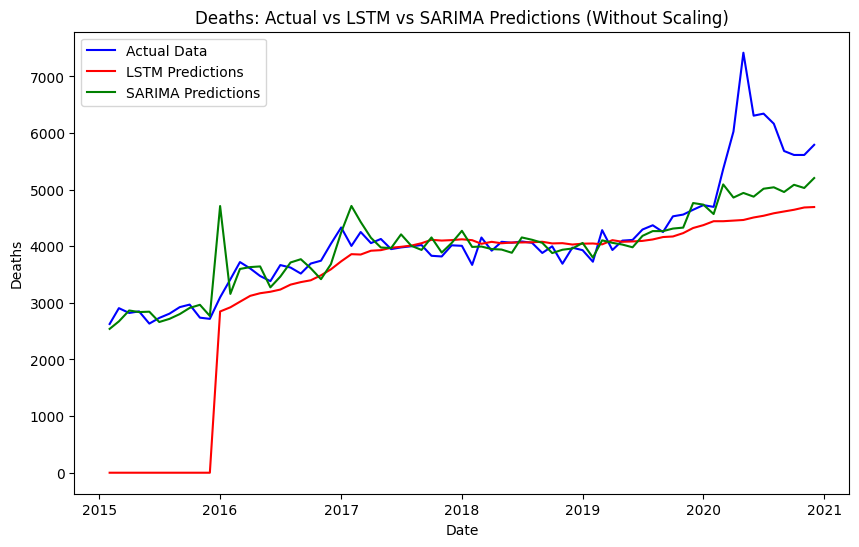

In [9]:
# LSTM calculate root mean squared error
print('LSTM')
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:len(testPredict)], testPredict[:len(testY)]))
print('Test Score: %.2f RMSE' % (testScore))

#SARIMA Error Metrics
print('SARIMA')
trainScore = np.sqrt(mean_squared_error(trainY, sarima_predictions[1:len(trainPredict)+1]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, sarima_predictions[len(trainPredict):len(trainPredict)+len(testY)]))
print('Test Score: %.2f RMSE' % (testScore))

plt.figure(figsize=(10, 6))
plt.plot(plottable.index, plottable['Deaths'], label='Actual Data', color='blue')
plt.plot(plottable.index, plottable['LSTM Predictions'], label='LSTM Predictions', color='red')
plt.plot(plottable.index, plottable['SARIMA Predictions'], label='SARIMA Predictions', color='green')
plt.title('Deaths: Actual vs LSTM vs SARIMA Predictions (Without Scaling)')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.show()

In [10]:
testY

array([4696, 5365, 6027, 7419, 6307, 6343, 6165, 5683, 5613, 5613, 5792])

In [11]:
def calculate_confidence_intervals(predictions, alpha=0.05):
    # Calculate mean and standard deviation
    mean_pred = np.mean(predictions)
    std_pred = np.std(predictions)
    
    # Calculate the z-score for the confidence level
    z_score = 1.96  # for 95% confidence
    margin_of_error = z_score * (std_pred / np.sqrt(len(predictions)))
    
    lower_bound = predictions - margin_of_error
    upper_bound = predictions + margin_of_error
    
    return lower_bound, upper_bound

sarimaTestPredict = df[df['Month'] > '2020-01-01']['SARIMA Predictions']
# Calculate confidence intervals
lower_bound_test, upper_bound_test = calculate_confidence_intervals(testPredict)
lower_bound_sarima, upper_bound_sarima = calculate_confidence_intervals(sarimaTestPredict)

In [12]:
sarimaTestPredict

61    4569.357214
62    5092.554794
63    4860.585533
64    4942.206500
65    4876.638922
66    5016.516000
67    5041.705897
68    4958.628025
69    5086.221253
70    5029.753481
71    5205.366131
Name: SARIMA Predictions, dtype: float64

In [13]:
testPredict

array([4442.727 , 4453.5566, 4464.598 , 4508.681 , 4539.0044, 4583.1094,
       4614.778 , 4644.7544, 4685.3276, 4693.248 ], dtype=float32)

In [14]:
def calculate_overlap(lower1, upper1, lower2, upper2):
    # Initialize overlap count
    overlap_count = 0

    for l1, u1, l2, u2 in zip(lower1, upper1, lower2, upper2):
        # Check for overlap
        if u1 >= l2 and l1 <= u2:
            overlap_count += 1

    # Calculate percent overlap
    percent_overlap = (overlap_count / len(lower1)) * 100
    return percent_overlap

# Calculate percent overlap
percent_overlap = calculate_overlap(lower_bound_test, upper_bound_test, lower_bound_sarima, upper_bound_sarima)

print(f'Percent Overlap: {percent_overlap:.2f}%')

Percent Overlap: 10.00%


In [15]:
plottable

,Deaths,LSTM Predictions,SARIMA Predictions
Month,,,
2015-02-01,2627,0.000000,2540.838172
2015-03-01,2907,0.000000,2673.336257
2015-04-01,2822,0.000000,2865.711655
2015-05-01,2850,0.000000,2837.851862
2015-06-01,2634,0.000000,2844.503804
...,...,...,...
2020-08-01,6165,4583.109375,5041.705897
2020-09-01,5683,4614.777832,4958.628025
2020-10-01,5613,4644.754395,5086.221253
